# Logistic Regression — Baseline Model
## Tujuan Notebook
- Membangun baseline Logistic Regression
- Mengevaluasi performa awal model
- Menjadi acuan pembanding untuk model lain 

Belum tuning hyperparameter di sini (itu di notebook berikutnya).

## Import Library

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report
)

import matplotlib.pyplot as plt


## Load Dataset (Hasil Feature Engineering)

In [2]:
df = pd.read_csv('../../data/processed/df_model.csv')

In [3]:
df.shape

(307511, 148)

In [4]:
df.head()

,TARGET,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,...,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,OCCUPATION_TYPE_nan,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_HOUSING_TYPE_nan
0,1,0,1,0,351000.0,0.018801,-3648.0,-2120,NaN,1,...,False,False,False,False,True,False,False,False,False,False
1,0,0,0,0,1129500.0,0.003541,-1186.0,-291,NaN,1,...,False,False,False,False,True,False,False,False,False,False
2,0,1,1,0,135000.0,0.010032,-4260.0,-2531,26.0,1,...,False,False,False,False,True,False,False,False,False,False
3,0,0,1,0,297000.0,0.008019,-9833.0,-2437,NaN,1,...,False,False,False,False,True,False,False,False,False,False
4,0,0,1,0,513000.0,0.028663,-4311.0,-3458,NaN,1,...,False,False,False,False,True,False,False,False,False,False


## Feature and Target

In [5]:
X = df.drop(columns=['TARGET'])
y = df['TARGET']

## Train / Validation Split

In [6]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


## Missing Value Imputation

In [10]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

## Feature Scaling

In [11]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

## Check data 

In [12]:
pd.Series(imputer.statistics_, index=X.columns).isnull().sum()

np.int64(0)

In [13]:
X.isnull().mean().sort_values(ascending=False).head(10)

COMMONAREA_MEDI             0.698723
COMMONAREA_MODE             0.698723
COMMONAREA_AVG              0.698723
NONLIVINGAPARTMENTS_AVG     0.694330
NONLIVINGAPARTMENTS_MODE    0.694330
NONLIVINGAPARTMENTS_MEDI    0.694330
LIVINGAPARTMENTS_MEDI       0.683550
LIVINGAPARTMENTS_AVG        0.683550
LIVINGAPARTMENTS_MODE       0.683550
FLOORSMIN_AVG               0.678486
dtype: float64

Missing values pada fitur numerik ditangani menggunakan median imputation sebelum proses scaling dan pemodelan, 
untuk menjaga stabilitas model dan menghindari bias akibat penghapusan data.


## Train Logistic Regression (Baseline)

In [14]:
logreg = LogisticRegression(
    max_iter=1000,
    solver='lbfgs'
)

logreg.fit(X_train_scaled, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

## Prediction and Probability

In [15]:
y_val_pred = logreg.predict(X_val_scaled)
y_val_proba = logreg.predict_proba(X_val_scaled)[:, 1]

## ROC-AUC (Main Metrics)

In [16]:
roc_auc = roc_auc_score(y_val, y_val_proba)
roc_auc

0.7468357172961801

## ROC Curve

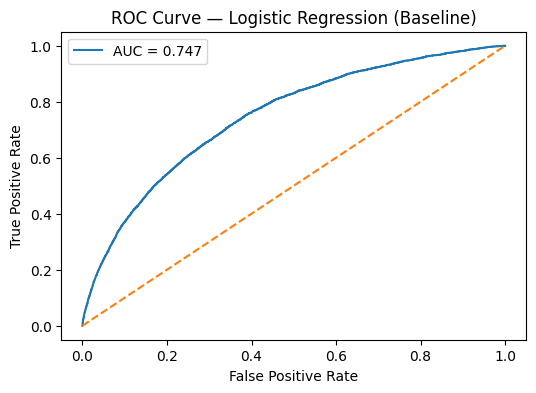

In [17]:
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1], [0,1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — Logistic Regression (Baseline)')
plt.legend()
plt.show()


## Confusion Matrix 

In [20]:
confusion_matrix(y_val, y_val_pred)

array([[56496,    42],
       [ 4913,    52]])

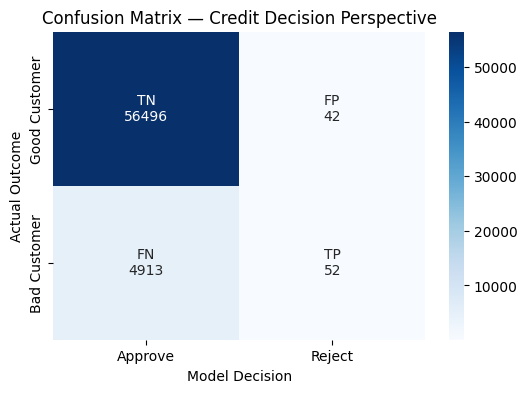

In [24]:
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_val, y_val_pred)

tn, fp, fn, tp = cm.ravel()

plt.figure(figsize=(6,4))
sns.heatmap(
    cm,
    annot=[
        [f'TN\n{tn}', f'FP\n{fp}'],
        [f'FN\n{fn}', f'TP\n{tp}']
    ],
    fmt='',
    cmap='Blues',
    xticklabels=['Approve', 'Reject'],
    yticklabels=['Good Customer', 'Bad Customer']
)

plt.title('Confusion Matrix — Credit Decision Perspective')
plt.xlabel('Model Decision')
plt.ylabel('Actual Outcome')
plt.show()


In [21]:
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.55      0.01      0.02      4965

    accuracy                           0.92     61503
   macro avg       0.74      0.50      0.49     61503
weighted avg       0.89      0.92      0.88     61503



Confusion matrix digunakan untuk mengevaluasi performa model pada threshold tertentu, <br>
serta memahami trade-off antara risiko gagal bayar dan potensi kehilangan peluang bisnis.

## KS Statistic

In [25]:
from scipy.stats import ks_2samp

ks = ks_2samp(
    y_val_proba[y_val == 0],
    y_val_proba[y_val == 1]
).statistic

ks

np.float64(0.36599111107691223)

## Feature Importance (Interpretavility)

In [26]:
feature_importance = pd.Series(
    logreg.coef_[0],
    index=X.columns
).sort_values(key=abs, ascending=False)

feature_importance.head(15)

EXT_SOURCE_3                  -0.455393
AMT_GOODS_PRICE               -0.422984
EXT_SOURCE_2                  -0.387157
LOG_CREDIT                     0.375624
OCCUPATION_TYPE_Laborers       0.180731
FLAG_DOCUMENT_3                0.171096
EXT_SOURCE_1                  -0.170026
EMPLOYED_YEARS                -0.169388
OCCUPATION_TYPE_Drivers        0.154147
REGION_RATING_CLIENT_W_CITY    0.149721
OCCUPATION_TYPE_nan            0.135811
ANNUITY_INCOME_RATIO           0.107483
LOG_INCOME                     0.107360
FLAG_OWN_CAR                  -0.103567
OCCUPATION_TYPE_Sales staff    0.097678
dtype: float64

## Logistic Regression — Baseline Summary

Model Logistic Regression digunakan sebagai baseline karena sifatnya yang interpretable dan umum digunakan pada credit scoring.  
Hasil evaluasi menunjukkan bahwa fitur-fitur finansial berbasis rasio serta stabilitas pekerjaan memiliki kontribusi terbesar dalam membedakan risiko gagal bayar.
